In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Arbitrage with FOREX Rates

In [2]:
# we take some example exchange rates between currencies and 
# build a pandas dataframe with these data
rates = [
    [1, 0.23, 0.25, 16.43, 18.21, 4.94],
    [4.34, 1, 1.11, 71.40, 79.09, 21.44],
    [3.93, 0.90, 1, 64.52, 71.48, 19.37],
    [0.061, 0.014, 0.015, 1, 1.11, 0.30],
    [0.055, 0.013, 0.014, 0.90, 1, 0.27],
    [0.20, 0.047, 0.052, 3.33, 3.69, 1],
]
currencies = ('PLN', 'EUR', 'USD', 'RUB', 'INR', 'MXN')
rates_df = pd.DataFrame(
    data=rates, columns=currencies, index=currencies
)

In [3]:
rates_df

,PLN,EUR,USD,RUB,INR,MXN
PLN,1.000,0.230,0.250,16.43,18.21,4.94
EUR,4.340,1.000,1.110,71.40,79.09,21.44
USD,3.930,0.900,1.000,64.52,71.48,19.37
RUB,0.061,0.014,0.015,1.00,1.11,0.30
INR,0.055,0.013,0.014,0.90,1.00,0.27
MXN,0.200,0.047,0.052,3.33,3.69,1.00


In [4]:
# we now use the currencies as nodes in a graph, and the edge connecting two
# nodes, u to v, represents the exchange rate of u to v
g_rates = nx.from_numpy_matrix(
    rates_df.values, parallel_edges=True, create_using=nx.MultiDiGraph()
)
print(nx.info(g_rates))

Name: 
Type: MultiDiGraph
Number of nodes: 6
Number of edges: 36
Average in degree:   6.0000
Average out degree:   6.0000


In [5]:
label_mapping = {idx: val for idx, val in enumerate(rates_df.columns)}
g_rates = nx.relabel_nodes(g_rates, label_mapping)

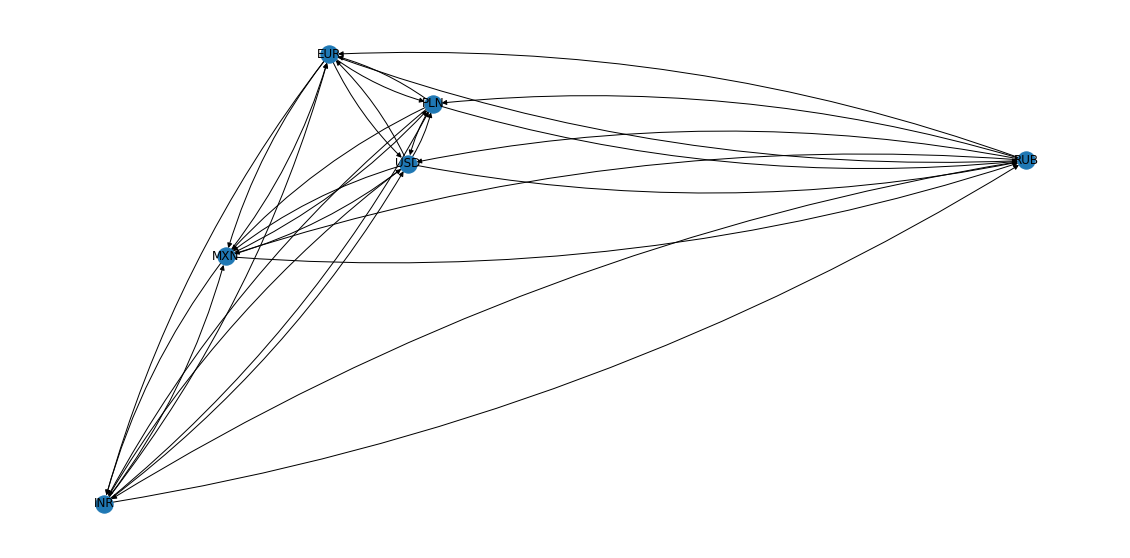

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
nx.draw(g_rates, with_labels=True, arrows = True, connectionstyle='arc3, rad = 0.1', ax=ax)

By definition, an arbitrage opportunity arises when we can exchange one currency to another (or a series of others) and back to the original currency at current market price, and end up with more money than we started with, risk-free.

In terms of our graph, what this means is that we can travel from one node to a series of others, returning at the original node, and multiplying the weights of the edges we travelled across returns a number larger than 1. 

More formally, if we take the path `u -> v -> w -> u` with edges `uv, vw, wu`, then, 

$$
w(uv) \cdot w(vw) \cdot w(wu) > 1
$$

Note that,

$$
(-\log(e_1)) + (-\log(e_2)) + ... + (-\log(e_n)) = - \log (e_1 \cdot e_2 \cdot ... \cdot e_n)
$$

and also that $-\log(x) > 0$ only if $x$ is greater than $1$.

We will thus take the negative logarithm of each edge so that when cycle weights are calculated, a negative cycle will represent an arbitrage opportunity in our market.

[Source: [dailycodingproblem.com](https://www.dailycodingproblem.com/blog/how-to-find-arbitrage-opportunities-in-python)]

In [7]:
neg_log_rates_df = rates_df.applymap(lambda x: -np.log(x))
neg_log_rates_df

,PLN,EUR,USD,RUB,INR,MXN
PLN,-0.000000,1.469676,1.386294,-2.799109,-2.901971,-1.597365
EUR,-1.467874,-0.000000,-0.104360,-4.268298,-4.370586,-3.065258
USD,-1.368639,0.105361,-0.000000,-4.166975,-4.269418,-2.963725
RUB,2.796881,4.268698,4.199705,-0.000000,-0.104360,1.203973
INR,2.900422,4.342806,4.268698,0.105361,-0.000000,1.309333
MXN,1.609438,3.057608,2.956512,-1.202972,-1.305626,-0.000000


In [8]:
g_neg_log_rates = nx.from_numpy_matrix(
    neg_log_rates_df.values, parallel_edges=True, create_using=nx.MultiDiGraph()
)
label_mapping = {idx: val for idx, val in enumerate(neg_log_rates_df.columns)}
g_neg_log_rates = nx.relabel_nodes(g_neg_log_rates, label_mapping)

In [9]:
def find_arb(G, start="USD"):
    # we use the Bellman-Ford algorithm to detect negative cycle in the graph
    if nx.negative_edge_cycle(G):
        cycles = nx.simple_cycles(G)
        for cycle in cycles:
            edges = [(cycle[i], cycle[i + 1])  for i in range(0, len(cycle)-1)]
            cycle_weight = 0
            for edge in edges:
                u, v = edge[0], edge[1]
                # and calculate the weight of each negative cycle
                cycle_weight += G.get_edge_data(u,v)[0]['weight']
            if cycle_weight > 0:
                print(cycle, cycle_weight)
    else:
        print("No arbitrage opportunities :(")

In [10]:
find_arb(g_neg_log_rates)

['INR', 'MXN'] 1.3093333199837622
['INR', 'MXN', 'RUB'] 0.10636101599140968
['INR', 'MXN', 'RUB', 'USD'] 4.306066093871337
['INR', 'MXN', 'RUB', 'USD', 'EUR'] 4.411426609529163
['INR', 'MXN', 'RUB', 'USD', 'EUR', 'PLN'] 2.9435522614168494
['INR', 'MXN', 'RUB', 'USD', 'PLN'] 2.937426667990167
['INR', 'MXN', 'RUB', 'USD', 'PLN', 'EUR'] 4.407102638049109
['INR', 'MXN', 'RUB', 'EUR'] 4.3750589653582885
['INR', 'MXN', 'RUB', 'EUR', 'USD'] 4.2706989500340455
['INR', 'MXN', 'RUB', 'EUR', 'USD', 'PLN'] 2.9020595241528757
['INR', 'MXN', 'RUB', 'EUR', 'PLN'] 2.907184617245975
['INR', 'MXN', 'RUB', 'EUR', 'PLN', 'USD'] 4.293478978365866
['INR', 'MXN', 'RUB', 'PLN'] 2.9032424308002356
['INR', 'MXN', 'RUB', 'PLN', 'USD'] 4.289536791920126
['INR', 'MXN', 'RUB', 'PLN', 'USD', 'EUR'] 4.394897307577952
['INR', 'MXN', 'RUB', 'PLN', 'EUR'] 4.372918400859177
['INR', 'MXN', 'RUB', 'PLN', 'EUR', 'USD'] 4.268558385534934
['INR', 'MXN', 'USD'] 4.265844880384472
['INR', 'MXN', 'USD', 'RUB'] 0.09886962712746428

# Applications to Sports Trading

FOREX trading worked easily because there is an equivalency between certain contracts. In sports trading however, it is more difficult to find contracts that are equivalent. We will look to build portfolios of contracts that are equivalent, and then use these portfolios as nodes in our graph and apply the same logic as before.